In [0]:
df_otpw = spark.read.parquet(f"dbfs:/FileStore/Group_4_3/Data/Pipeline_Output/OTPW_60M_PARQUET")


In [0]:
from pyspark.sql.functions import col, count, avg, when, floor, log1p, expm1
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# === Step 0: Feature engineering and casting ===
df_feat = df_otpw \
    .withColumn("DEP_DELAY", col("DEP_DELAY").cast("double")) \
    .withColumn("PREV_DEP_DELAY", col("PREV_DEP_DELAY").cast("double")) \
    .withColumn("TIME_BETWEEN_ARR_AND_SCHEDULED_DEP", col("TIME_BETWEEN_ARR_AND_SCHEDULED_DEP").cast("double")) \
    .withColumn("CRS_DEP_TIME_MINUTES", col("CRS_DEP_TIME_MINUTES").cast("double")) \
    .withColumn("ORIGIN_CLOSENESS", col("ORIGIN_CLOSENESS").cast("double")) \
    .withColumn("CRS_DEP_X_PREV_DELAY", col("CRS_DEP_TIME_MINUTES") * col("PREV_DEP_DELAY")) \
    .withColumn("ARR_TIME_GAP_X_CRS_DEP", col("TIME_BETWEEN_ARR_AND_SCHEDULED_DEP") * col("CRS_DEP_TIME_MINUTES")) \
    .withColumn("DEP_HOUR", floor(col("CRS_DEP_TIME_MINUTES") / 60)) \
    .withColumn("DEP_DELAY_LOG", log1p(col("DEP_DELAY")))

# === Step 1: Temporal split ===
train_data = df_feat.filter(col("YEAR") < 2019)
test_data = df_feat.filter(col("YEAR") == 2019)

# === Step 2: Target encodings ===
mean_delay_carrier = train_data.groupBy("OP_UNIQUE_CARRIER").agg(avg("DEP_DELAY").alias("MEAN_DELAY_PER_CARRIER"))
mean_delay_hour = train_data.groupBy("DEP_HOUR").agg(avg("DEP_DELAY").alias("MEAN_DELAY_PER_HOUR"))
mean_delay_dest = train_data.groupBy("DEST").agg(avg("DEP_DELAY").alias("MEAN_DELAY_PER_DEST"))

df_joined = df_feat \
    .join(mean_delay_carrier, on="OP_UNIQUE_CARRIER", how="left") \
    .join(mean_delay_hour, on="DEP_HOUR", how="left") \
    .join(mean_delay_dest, on="DEST", how="left")

# === Step 3: Rare category flags ===
origin_counts = train_data.groupBy("ORIGIN").agg(count("*").alias("origin_count"))
dest_counts = train_data.groupBy("DEST").agg(count("*").alias("dest_count"))

df_flagged = df_joined \
    .join(origin_counts, on="ORIGIN", how="left") \
    .join(dest_counts, on="DEST", how="left") \
    .withColumn("IS_RARE_ORIGIN", when(col("origin_count") < 50, 1).otherwise(0)) \
    .withColumn("IS_RARE_DEST", when(col("dest_count") < 50, 1).otherwise(0))

# === Step 4: Define features ===
target = "DEP_DELAY_LOG"
all_features = [c for c in df_flagged.columns if c not in {"DEP_DELAY", target, "origin_count", "dest_count"}]
categorical_cols = [c for c in all_features if dict(df_flagged.dtypes)[c] == "string"]
numeric_cols = [c for c in all_features if dict(df_flagged.dtypes)[c] != "string"]

# === Step 5: Index + assemble features ===
indexers = [StringIndexer(inputCol=c, outputCol=c + "_idx", handleInvalid="keep") for c in categorical_cols]
indexed_features = [c + "_idx" for c in categorical_cols] + numeric_cols
assembler = VectorAssembler(inputCols=indexed_features, outputCol="features_unscaled")
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features")

# === Step 6: Model and pipeline ===
rf = RandomForestRegressor(featuresCol="features", labelCol=target, maxDepth=10, numTrees=100)
pipeline = Pipeline(stages=indexers + [assembler, scaler, rf])

# === Step 7: Filter and split ===
df_final = df_flagged.dropna(subset=[target] + all_features)
train = df_final.filter(col("YEAR") < 2019)
test = df_final.filter(col("YEAR") == 2019)

# === Step 8: Fit model and predict ===
model = pipeline.fit(train)

train_preds = model.transform(train).withColumn("prediction_exp", expm1(col("prediction"))).withColumn("label_exp", expm1(col(target)))
test_preds = model.transform(test).withColumn("prediction_exp", expm1(col("prediction"))).withColumn("label_exp", expm1(col(target)))

# === Step 9: Evaluate ===
evaluator = RegressionEvaluator(labelCol="label_exp", predictionCol="prediction_exp")

train_rmse_log = evaluator.setMetricName("rmse").evaluate(train_preds)
train_mae_log = evaluator.setMetricName("mae").evaluate(train_preds)

test_rmse_log = evaluator.setMetricName("rmse").evaluate(test_preds)
test_mae_log = evaluator.setMetricName("mae").evaluate(test_preds)

# === Step 10: Print metrics ===
print("📊 Training Evaluation (on original DEP_DELAY scale)")
print(f"📉 RMSE: {train_rmse_log:.2f}")
print(f"📉 MAE : {train_mae_log:.2f}")

print("\n📊 Test Evaluation (2019, on original DEP_DELAY scale)")
print(f"📉 RMSE: {test_rmse_log:.2f}")
print(f"📉 MAE : {test_mae_log:.2f}")


📊 Training Evaluation (on original DEP_DELAY scale)
📉 RMSE: 72.53
📉 MAE : 30.78

📊 Test Evaluation (2019, on original DEP_DELAY scale)
📉 RMSE: 87.44
📉 MAE : 36.81


# Make visual of performance when using log dep delay vs regular dep delay

In [0]:
from pyspark.sql.functions import col, count, avg, when, floor
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# === Step 0: Feature engineering and casting ===
df_feat = df_otpw \
    .withColumn("DEP_DELAY", col("DEP_DELAY").cast("double")) \
    .withColumn("PREV_DEP_DELAY", col("PREV_DEP_DELAY").cast("double")) \
    .withColumn("TIME_BETWEEN_ARR_AND_SCHEDULED_DEP", col("TIME_BETWEEN_ARR_AND_SCHEDULED_DEP").cast("double")) \
    .withColumn("CRS_DEP_TIME_MINUTES", col("CRS_DEP_TIME_MINUTES").cast("double")) \
    .withColumn("ORIGIN_CLOSENESS", col("ORIGIN_CLOSENESS").cast("double")) \
    .withColumn("CRS_DEP_X_PREV_DELAY", col("CRS_DEP_TIME_MINUTES") * col("PREV_DEP_DELAY")) \
    .withColumn("ARR_TIME_GAP_X_CRS_DEP", col("TIME_BETWEEN_ARR_AND_SCHEDULED_DEP") * col("CRS_DEP_TIME_MINUTES")) \
    .withColumn("DEP_HOUR", floor(col("CRS_DEP_TIME_MINUTES") / 60))

# === Step 1: Temporal split ===
train_data = df_feat.filter(col("YEAR") < 2019)
test_data = df_feat.filter(col("YEAR") == 2019)

# === Step 2: Target encodings ===
mean_delay_carrier = train_data.groupBy("OP_UNIQUE_CARRIER").agg(avg("DEP_DELAY").alias("MEAN_DELAY_PER_CARRIER"))
mean_delay_hour = train_data.groupBy("DEP_HOUR").agg(avg("DEP_DELAY").alias("MEAN_DELAY_PER_HOUR"))
mean_delay_dest = train_data.groupBy("DEST").agg(avg("DEP_DELAY").alias("MEAN_DELAY_PER_DEST"))

df_joined = df_feat \
    .join(mean_delay_carrier, on="OP_UNIQUE_CARRIER", how="left") \
    .join(mean_delay_hour, on="DEP_HOUR", how="left") \
    .join(mean_delay_dest, on="DEST", how="left")

# === Step 3: Rare category flags ===
origin_counts = train_data.groupBy("ORIGIN").agg(count("*").alias("origin_count"))
dest_counts = train_data.groupBy("DEST").agg(count("*").alias("dest_count"))

df_flagged = df_joined \
    .join(origin_counts, on="ORIGIN", how="left") \
    .join(dest_counts, on="DEST", how="left") \
    .withColumn("IS_RARE_ORIGIN", when(col("origin_count") < 50, 1).otherwise(0)) \
    .withColumn("IS_RARE_DEST", when(col("dest_count") < 50, 1).otherwise(0))

# === Step 4: Define features ===
target = "DEP_DELAY"
all_features = [c for c in df_flagged.columns if c != target and c not in {"origin_count", "dest_count"}]
categorical_cols = [c for c in all_features if dict(df_flagged.dtypes)[c] == "string"]
numeric_cols = [c for c in all_features if dict(df_flagged.dtypes)[c] != "string"]

# === Step 5: Index + assemble features ===
indexers = [StringIndexer(inputCol=c, outputCol=c + "_idx", handleInvalid="keep") for c in categorical_cols]
indexed_features = [c + "_idx" for c in categorical_cols] + numeric_cols
assembler = VectorAssembler(inputCols=indexed_features, outputCol="features_unscaled")
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features")

# === Step 6: Model and pipeline ===
rf = RandomForestRegressor(featuresCol="features", labelCol=target, maxDepth=10, numTrees=100)
pipeline = Pipeline(stages=indexers + [assembler, scaler, rf])

# === Step 7: Filter and split ===
df_final = df_flagged.dropna(subset=[target] + all_features)
train = df_final.filter(col("YEAR") < 2019)
test = df_final.filter(col("YEAR") == 2019)

# === Step 8: Fit model and predict ===
model = pipeline.fit(train)
train_preds = model.transform(train)
test_preds = model.transform(test)

# === Step 9: Evaluate ===
evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction")

train_rmse_raw = evaluator.setMetricName("rmse").evaluate(train_preds)
train_mae_raw = evaluator.setMetricName("mae").evaluate(train_preds)

test_rmse_raw = evaluator.setMetricName("rmse").evaluate(test_preds)
test_mae_raw = evaluator.setMetricName("mae").evaluate(test_preds)

# === Step 10: Print metrics ===
print("📊 Training Evaluation")
print(f"📉 RMSE: {train_rmse_raw:.2f}")
print(f"📉 MAE : {train_mae_raw:.2f}")

print("\n📊 Test Evaluation (2019)")
print(f"📉 RMSE: {test_rmse_raw:.2f}")
print(f"📉 MAE : {test_mae_raw:.2f}")


📊 Training Evaluation
📉 RMSE: 46.23
📉 MAE : 21.91

📊 Test Evaluation (2019)
📉 RMSE: 58.33
📉 MAE : 25.39


In [0]:
results_raw = {
    "Model": "Raw DEP_DELAY",
    "Train_RMSE": train_rmse_raw,
    "Train_MAE": train_mae_raw,
    "Test_RMSE": test_rmse_raw,
    "Test_MAE": test_mae_raw
}
results_log = {
    "Model": "Log(1 + DEP_DELAY)",
    "Train_RMSE": train_rmse_log,
    "Train_MAE": train_mae_log,
    "Test_RMSE": test_rmse_log,
    "Test_MAE": test_mae_log
}


/root/.ipykernel/1684/command-4605218292336512-2731908236:26: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/databricks/python/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


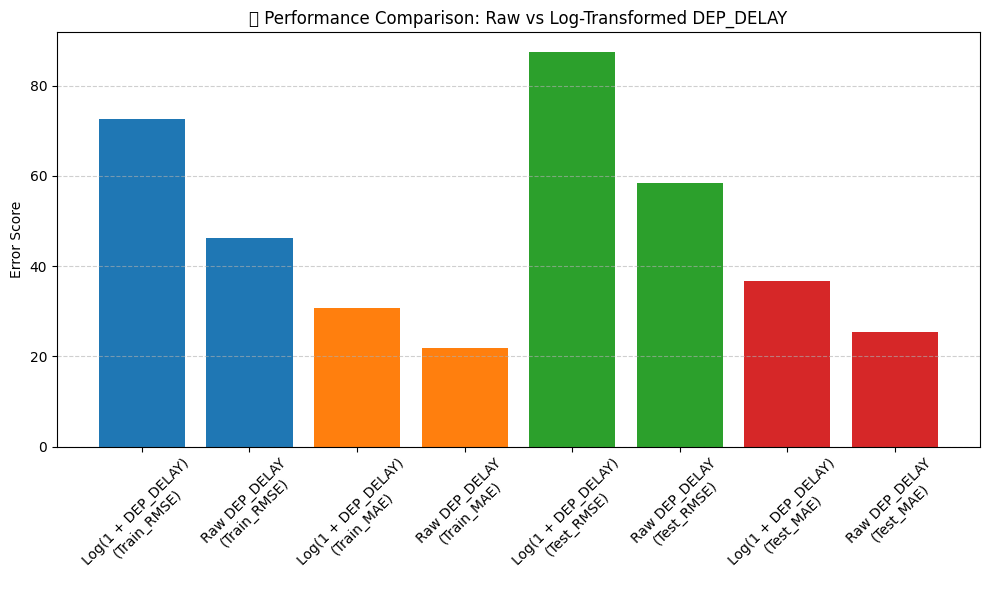

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# === Combine both model results ===
results_list = [results_raw, results_log]
df_results = pd.DataFrame(results_list)

# === Convert to long format for plotting ===
df_melted = df_results.melt(id_vars="Model", var_name="Metric", value_name="Score")

# === Control metric order for visual clarity ===
metric_order = ["Train_RMSE", "Train_MAE", "Test_RMSE", "Test_MAE"]
df_melted["Metric"] = pd.Categorical(df_melted["Metric"], categories=metric_order, ordered=True)
df_melted = df_melted.sort_values(["Metric", "Model"])

# === Bar Plot ===
plt.figure(figsize=(10, 6))
for metric in metric_order:
    subset = df_melted[df_melted["Metric"] == metric]
    plt.bar(subset["Model"] + f"\n({metric})", subset["Score"], label=metric)

plt.title("📊 Performance Comparison: Raw vs Log-Transformed DEP_DELAY")
plt.ylabel("Error Score")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


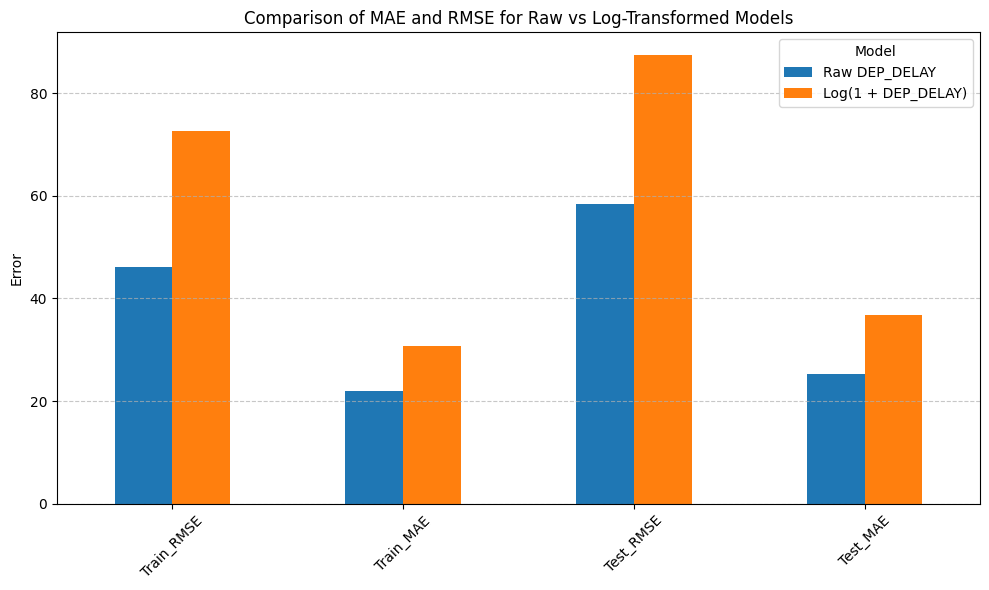

In [0]:
# Grouped bar plot (better layout)
df_grouped = df_results.set_index("Model").T
df_grouped.plot(kind='bar', figsize=(10, 6))

plt.ylabel("Error")
plt.title("Comparison of MAE and RMSE for Raw vs Log-Transformed Models")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


 Improvements to Your Raw Random Forest Pipeline
✅ 1. Add More Informative Engineered Features
We’ll add:

Lag features (e.g., PREV2_DEP_DELAY, PREV2_ARRIVAL_DELAY)

Interaction terms (e.g., ORIGIN_CLOSENESS * DEP_HOUR)

Calendar features (e.g., IS_WEEKEND, IS_MONDAY_AM)

Weather interactions if available (e.g., HOURLY_VISIBILITY, HOURLY_WIND_SPEED × delays)

✅ 2. Tune Hyperparameters
We'll increase numTrees, test deeper trees (maxDepth=15), and set featureSubsetStrategy='sqrt' to reduce overfitting.

✅ 3. Avoid StandardScaler for Tree Models
Tree-based models like Random Forest do not benefit from standardization — so we remove StandardScaler.

✅ 4. Stronger Target Encoding
Add additional encodings:

By ORIGIN

By (ORIGIN, DEST) pair

Delay rate per DAY_OF_WEEK

In [0]:
from pyspark.sql.functions import col, count, avg, when, floor, dayofweek, lit
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# === Step 0: Feature engineering ===
df_feat = df_otpw \
    .withColumn("DEP_DELAY", col("DEP_DELAY").cast("double")) \
    .withColumn("PREV_DEP_DELAY", col("PREV_DEP_DELAY").cast("double")) \
    .withColumn("PREV2_DEP_DELAY", col("PREV2_DEP_DELAY").cast("double")) \
    .withColumn("PREV2_ARRIVAL_DELAY", col("PREV2_ARRIVAL_DELAY").cast("double")) \
    .withColumn("CRS_DEP_TIME_MINUTES", col("CRS_DEP_TIME_MINUTES").cast("double")) \
    .withColumn("TIME_BETWEEN_ARR_AND_SCHEDULED_DEP", col("TIME_BETWEEN_ARR_AND_SCHEDULED_DEP").cast("double")) \
    .withColumn("ORIGIN_CLOSENESS", col("ORIGIN_CLOSENESS").cast("double")) \
    .withColumn("DEP_HOUR", floor(col("CRS_DEP_TIME_MINUTES") / 60)) \
    .withColumn("IS_WEEKEND", when(col("DAY_OF_WEEK").isin(6, 7), 1).otherwise(0)) \
    .withColumn("DEP_TIME_X_CLOSENESS", col("CRS_DEP_TIME_MINUTES") * col("ORIGIN_CLOSENESS")) \
    .withColumn("PREV_DELAY_X_DEP_HOUR", col("PREV_DEP_DELAY") * col("DEP_HOUR"))

# === Step 1: Temporal split ===
train_data = df_feat.filter(col("YEAR") < 2019)
test_data = df_feat.filter(col("YEAR") == 2019)

# === Step 2: Target encodings (expanded) ===
mean_delay_carrier = train_data.groupBy("OP_UNIQUE_CARRIER").agg(avg("DEP_DELAY").alias("MEAN_DELAY_PER_CARRIER"))
mean_delay_hour = train_data.groupBy("DEP_HOUR").agg(avg("DEP_DELAY").alias("MEAN_DELAY_PER_HOUR"))
mean_delay_dest = train_data.groupBy("DEST").agg(avg("DEP_DELAY").alias("MEAN_DELAY_PER_DEST"))
mean_delay_origin = train_data.groupBy("ORIGIN").agg(avg("DEP_DELAY").alias("MEAN_DELAY_PER_ORIGIN"))
mean_delay_od_pair = train_data.groupBy("ORIGIN", "DEST").agg(avg("DEP_DELAY").alias("MEAN_DELAY_OD_PAIR"))

df_joined = df_feat \
    .join(mean_delay_carrier, on="OP_UNIQUE_CARRIER", how="left") \
    .join(mean_delay_hour, on="DEP_HOUR", how="left") \
    .join(mean_delay_dest, on="DEST", how="left") \
    .join(mean_delay_origin, on="ORIGIN", how="left") \
    .join(mean_delay_od_pair, on=["ORIGIN", "DEST"], how="left")

# === Step 3: Rare category flags ===
origin_counts = train_data.groupBy("ORIGIN").agg(count("*").alias("origin_count"))
dest_counts = train_data.groupBy("DEST").agg(count("*").alias("dest_count"))

df_flagged = df_joined \
    .join(origin_counts, on="ORIGIN", how="left") \
    .join(dest_counts, on="DEST", how="left") \
    .withColumn("IS_RARE_ORIGIN", when(col("origin_count") < 50, 1).otherwise(0)) \
    .withColumn("IS_RARE_DEST", when(col("dest_count") < 50, 1).otherwise(0))

# === Step 4: Define features ===
target = "DEP_DELAY"
all_features = [c for c in df_flagged.columns if c != target and c not in {"origin_count", "dest_count"}]
categorical_cols = [c for c in all_features if dict(df_flagged.dtypes)[c] == "string"]
numeric_cols = [c for c in all_features if dict(df_flagged.dtypes)[c] != "string"]

# === Step 5: Index + assemble features ===
indexers = [StringIndexer(inputCol=c, outputCol=c + "_idx", handleInvalid="keep") for c in categorical_cols]
indexed_features = [c + "_idx" for c in categorical_cols] + numeric_cols
assembler = VectorAssembler(inputCols=indexed_features, outputCol="features")

# === Step 6: Model and pipeline ===
rf = RandomForestRegressor(    maxBins=7000,

    featuresCol="features",
    labelCol=target,
    maxDepth=10,
    numTrees=100,
    featureSubsetStrategy="sqrt"
)
pipeline = Pipeline(stages=indexers + [assembler, rf])

# === Step 7: Filter and split ===
df_final = df_flagged.dropna(subset=[target] + all_features)
train = df_final.filter(col("YEAR") < 2019)
test = df_final.filter(col("YEAR") == 2019)

# === Step 8: Fit model and predict ===
model = pipeline.fit(train)
train_preds = model.transform(train)
test_preds = model.transform(test)

# === Step 9: Evaluate ===
evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction")

train_rmse = evaluator.setMetricName("rmse").evaluate(train_preds)
train_mae = evaluator.setMetricName("mae").evaluate(train_preds)

test_rmse = evaluator.setMetricName("rmse").evaluate(test_preds)
test_mae = evaluator.setMetricName("mae").evaluate(test_preds)

# === Step 10: Print metrics ===
print("📊 Training Evaluation")
print(f"📉 RMSE: {train_rmse:.2f}")
print(f"📉 MAE : {train_mae:.2f}")

print("\n📊 Test Evaluation (2019)")
print(f"📉 RMSE: {test_rmse:.2f}")
print(f"📉 MAE : {test_mae:.2f}")


📊 Training Evaluation
📉 RMSE: 39.86
📉 MAE : 23.68

📊 Test Evaluation (2019)
📉 RMSE: 80.27
📉 MAE : 51.06


# RUN A GRID SEARCH 